In [1]:
import tensorflow.keras as keras
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import sys

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Input dataset
Dataset used is celebA : https://www.kaggle.com/jessicali9530/celeba-dataset

(64, 64, 3)
len dataset :  3166


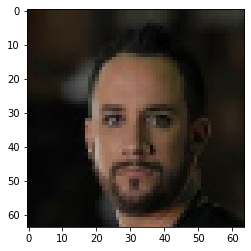

In [3]:
IM_DIM = 64
@tf.function
def im_preprocessing(im_path) :
    im_file = tf.io.read_file(im_path)
    im = tf.io.decode_jpeg(im_file)
    im = tf.image.convert_image_dtype(im, tf.float32)
    im = tf.image.crop_to_bounding_box(im, 20,0,178,178)
    im = tf.image.resize(im, [IM_DIM, IM_DIM])
    return(im)

batch_size = 64
im_patern = "./data/img_align_celeba/img_align_celeba/*.jpg"
files_dataset = tf.data.Dataset.list_files(im_patern)
im_dataset = files_dataset.map(im_preprocessing)
im_dataset_batch = im_dataset.batch(batch_size)

for x in im_dataset.take(1) :
    print(x.numpy().shape)
    print("len dataset : ", tf.data.experimental.cardinality(im_dataset_batch).numpy())
    plt.imshow(x)

## Making models

In [4]:
DEPTH = 32
LATENT_DEPTH = 512
K_SIZE = 5

In [5]:
def sampling(args):
    mean, logsigma = args
    epsilon = tf.random.normal(shape=(LATENT_DEPTH,), mean=0., stddev=1.0)
    return mean + tf.exp(logsigma / 2) * epsilon

def encoder():
    input_E = keras.layers.Input(shape=(IM_DIM, IM_DIM, 3))
    
    X = keras.layers.Conv2D(filters=DEPTH*2, kernel_size=K_SIZE, strides=2, padding='same')(input_E)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)

    X = keras.layers.Conv2D(filters=DEPTH*4, kernel_size=K_SIZE, strides=2, padding='same')(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)

    X = keras.layers.Conv2D(filters=DEPTH*8, kernel_size=K_SIZE, strides=2, padding='same')(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)
    
    
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(LATENT_DEPTH)(X)    
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)
    
    mean = keras.layers.Dense(LATENT_DEPTH,activation="tanh")(X)
    logsigma = keras.layers.Dense(LATENT_DEPTH,activation="tanh")(X)
    latent = keras.layers.Lambda(sampling, output_shape=(LATENT_DEPTH,))([mean, logsigma])
    
    kl_loss = 1 + logsigma - keras.backend.square(mean) - keras.backend.exp(logsigma)
    kl_loss = keras.backend.mean(kl_loss, axis=-1)
    kl_loss *= -0.5
    
    return keras.models.Model(input_E, [latent,kl_loss])

def generator():
    input_G = keras.layers.Input(shape=(LATENT_DEPTH,))

    X = keras.layers.Dense(8*8*256)(input_G)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)
    X = keras.layers.Reshape((8, 8, DEPTH * 8))(X)
    
    X = keras.layers.Conv2DTranspose(filters=DEPTH*8, kernel_size=K_SIZE, strides=2, padding='same')(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)

    X = keras.layers.Conv2DTranspose(filters=DEPTH*4, kernel_size=K_SIZE, strides=2, padding='same')(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)
    
    X = keras.layers.Conv2DTranspose(filters=DEPTH, kernel_size=K_SIZE, strides=2, padding='same')(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)
    
    X = keras.layers.Conv2D(filters=3, kernel_size=K_SIZE, padding='same')(X)
    X = keras.layers.Activation('sigmoid')(X)

    return keras.models.Model(input_G, X)

def discriminator():
    input_D = keras.layers.Input(shape=(IM_DIM, IM_DIM, 3))
    
    X = keras.layers.Conv2D(filters=DEPTH, kernel_size=K_SIZE, strides=2, padding='same')(input_D)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)
    
    X = keras.layers.Conv2D(filters=DEPTH*4, kernel_size=K_SIZE, strides=2, padding='same')(input_D)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)
    X = keras.layers.BatchNormalization()(X)

    X = keras.layers.Conv2D(filters=DEPTH*8, kernel_size=K_SIZE, strides=2, padding='same')(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)

    X = keras.layers.Flatten()(X)
    inner_output = keras.layers.Dense(512)(X)
    X = keras.layers.BatchNormalization()(inner_output)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)
    
    output = keras.layers.Dense(1, use_bias=False)(X)    
    
    return keras.models.Model(input_D, [output, inner_output])

## Training
### VAE pre training

In [57]:
E = encoder()
G = generator()

E_opt = keras.optimizers.Adam(lr=0.0001)
G_opt = keras.optimizers.Adam(lr=0.0001)

kl_coef = 0.1

@tf.function
def train_step_vae(x):
    with tf.GradientTape(persistent=True) as tape :
        latent,kl_loss = E(x)
        reconstructed = G(latent)
        reconstructed_loss = tf.reduce_mean(tf.abs(x-reconstructed)) + kl_coef*tf.reduce_mean(kl_loss)
    E_grad = tape.gradient(reconstructed_loss,E.trainable_variables)
    G_grad = tape.gradient(reconstructed_loss,G.trainable_variables)
    E_opt.apply_gradients(zip(E_grad, E.trainable_variables))
    G_opt.apply_gradients(zip(G_grad, G.trainable_variables))
    return reconstructed_loss

stop = tf.data.experimental.cardinality(im_dataset_batch).numpy() 
for e in range(2) :
    bar = keras.utils.Progbar(stop)
    step = 0
    for x in im_dataset_batch :
        l = train_step_vae(x)
        bar.update(step, values=[("reconstruction loss", l)])
        if step >= stop:
            break    
        step += 1

G.save('saved-models/G_pretrained.h5')
E.save('saved-models/E_pretrained.h5')        

3165/3166 [============================>.] - ETA: 0s - reconstruction loss: 0.1208

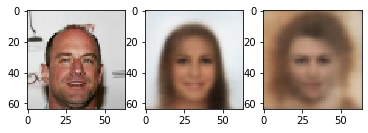

In [64]:
for x in im_dataset_batch.take(1) :
    pred = G(E(x))
    plt.subplot(131)
    plt.imshow(x[0])
    plt.subplot(132)
    plt.imshow(pred[0])
    plt.subplot(133)
    plt.imshow(G(np.random.normal(size=(1,LATENT_DEPTH)))[0])

### Discriminator pretraining

In [11]:
D = discriminator()
G = keras.models.load_model('saved-models/DG_pretrained.h5')
E = keras.models.load_model('saved-models/E_pretrained.h5')

conv_layers = [D.layers[1], D.layers[4]]
dens_layers = [D.layers[8], D.layers[11]]

weights_clipped = []
c_clipping = []
c0 = 10

for conv in conv_layers :
    weights_clipped += [conv.kernel, conv.bias]
    shape = conv.kernel.shape
    c_clipping += [c0/(shape[0]*shape[1]*shape[2]), c0]
    
for conv in dens_layers :
    weights_clipped += [conv.kernel]
    shape = conv.kernel.shape
    c_clipping += [c0/(shape[0])]
    if conv.bias is not None :
        weights_clipped += [conv.bias]
        c_clipping += [c0]
        
        
D_opt = keras.optimizers.Adam(lr=0.0001)

#@tf.function
def train_step_dis(x):
    lattent_r =  tf.random.normal((batch_size, LATENT_DEPTH))
    lattent,kl_loss = E(x)
    fake = G(lattent)
    
    with tf.GradientTape(persistent=True) as tape :
        dis_fake,dis_inner_fake = D(fake)
        dis_fake_r,_ = D(G(lattent_r))
        dis_true,dis_inner_true = D(x)

        f_dis_loss = tf.reduce_mean(dis_fake)
        r_dis_loss = tf.reduce_mean(dis_fake_r)
        t_dis_loss = tf.reduce_mean(dis_true)
        gan_loss = t_dis_loss - (f_dis_loss + r_dis_loss)/2 
        D_loss = gan_loss
        
    D_grad = tape.gradient(D_loss,D.trainable_variables)
    D_opt.apply_gradients(zip(D_grad, D.trainable_variables))
    for w,c in zip(weights_clipped, c_clipping) :
        w.assign(tf.clip_by_value(w,-c, c))
    return D_loss

step = 0
stop = tf.data.experimental.cardinality(im_dataset_batch).numpy() // 10
bar = keras.utils.Progbar(stop)
for x in im_dataset_batch :
    l = train_step_dis(x)
    bar.update(step, values=[("dis loss", l)])
    if step >= stop:
        break    
    step += 1

D.save('saved-models/D_pretrained.h5')

316/316 [==============================] - 144s 456ms/step - dis loss: -5.3921


### Main training 

In [6]:
for x in im_dataset_batch.take(1) :
    test_image = x

In [ ]:
D = keras.models.load_model('saved-models/D_pretrained.h5')
G = keras.models.load_model('saved-models/DG_pretrained.h5')
E = keras.models.load_model('saved-models/E_pretrained.h5')

E_opt = keras.optimizers.Adam(lr=0.00001)
G_opt = keras.optimizers.Adam(lr=0.00001)
D_opt = keras.optimizers.Adam(lr=0.00001)

conv_layers = [D.layers[1], D.layers[4]]
dens_layers = [D.layers[8], D.layers[11]]

weights_clipped = []
c_clipping = []
c0 = 10

for conv in conv_layers :
    weights_clipped += [conv.kernel, conv.bias]
    shape = conv.kernel.shape
    c_clipping += [c0/(shape[0]*shape[1]*shape[2]), c0]
    
for conv in dens_layers :
    weights_clipped += [conv.kernel]
    shape = conv.kernel.shape
    c_clipping += [c0/(shape[0])]
    if conv.bias is not None :
        weights_clipped += [conv.bias]
        c_clipping += [c0]

gan_loss_coef = 1.0
kl_coef = 0.01    

@tf.function
def train_step_vaegan(x):
    lattent_r =  tf.random.normal((batch_size, LATENT_DEPTH))
    with tf.GradientTape(persistent=True) as tape :
        lattent,kl_loss = E(x)
        fake = G(lattent)
        dis_fake,dis_inner_fake = D(fake)
        dis_fake_r,_ = D(G(lattent_r))
        dis_true,dis_inner_true = D(x)

        vae_inner = dis_inner_fake-dis_inner_true
        vae_inner = vae_inner*vae_inner

        kl_loss = tf.reduce_mean(kl_loss)
        vae_diff_loss = tf.reduce_mean(vae_inner)
        f_dis_loss = tf.reduce_mean(dis_fake)
        r_dis_loss = tf.reduce_mean(dis_fake_r)
        t_dis_loss = tf.reduce_mean(dis_true)
        gan_loss = t_dis_loss - (f_dis_loss + r_dis_loss)/2 
        E_loss = vae_diff_loss + kl_coef*kl_loss
        G_loss = vae_diff_loss - gan_loss_coef*gan_loss
        D_loss = gan_loss
    
    vae_loss = tf.reduce_mean(tf.abs(x-fake)) 
    
    E_grad = tape.gradient(E_loss,E.trainable_variables)
    G_grad = tape.gradient(G_loss,G.trainable_variables)
    D_grad = tape.gradient(D_loss,D.trainable_variables)
    del tape
    E_opt.apply_gradients(zip(E_grad, E.trainable_variables))
    G_opt.apply_gradients(zip(G_grad, G.trainable_variables))
    D_opt.apply_gradients(zip(D_grad, D.trainable_variables))
    for w,c in zip(weights_clipped, c_clipping) :
        w.assign(tf.clip_by_value(w,-c, c))
    return [gan_loss, vae_loss, f_dis_loss, r_dis_loss, t_dis_loss, vae_diff_loss, E_loss, D_loss, kl_loss]
    
#@tf.function
def train_step_vaegan_only_dis(x):
    lattent_r =  tf.random.normal((batch_size, LATENT_DEPTH))
    with tf.GradientTape(persistent=True) as tape :
        lattent,kl_loss = E(x)
        fake = G(lattent)
        dis_fake,dis_inner_fake = D(fake)
        dis_fake_r,_ = D(G(lattent_r))
        dis_true,dis_inner_true = D(x)

        f_dis_loss = tf.reduce_mean(dis_fake)
        r_dis_loss = tf.reduce_mean(dis_fake_r)
        t_dis_loss = tf.reduce_mean(dis_true)
        
        gan_loss = t_dis_loss - (f_dis_loss + r_dis_loss)/2 
        D_loss = gan_loss
        
    vae_inner = dis_inner_fake-dis_inner_true
    vae_inner = vae_inner*vae_inner
    kl_loss = tf.reduce_mean(kl_loss)
    vae_diff_loss = tf.reduce_mean(vae_inner)
    E_loss = vae_diff_loss + kl_coef*kl_loss
    G_loss = vae_diff_loss - gan_loss_coef*gan_loss
    vae_loss = tf.reduce_mean(tf.abs(x-fake)) 

    D_grad = tape.gradient(D_loss,D.trainable_variables)
    del tape
    D_opt.apply_gradients(zip(D_grad, D.trainable_variables))
    for w,c in zip(weights_clipped, c_clipping) :
        w.assign(tf.clip_by_value(w,-c, c))
    return [gan_loss, vae_loss, f_dis_loss, r_dis_loss, t_dis_loss, vae_diff_loss, E_loss, D_loss, kl_loss]       


metrics_names = ["gan_loss", "vae_loss", "fake_dis_loss", "r_dis_loss", "t_dis_loss", "vae_inner_loss", "E_loss", "D_loss", "kl_loss"]
metrics = []
for m in metrics_names :
    metrics.append(tf.keras.metrics.Mean('m', dtype=tf.float32))
    
def print_metrics() :
    s = ""
    for name,metric in zip(metrics_names,metrics) :
        s+= " " + name + " " + str(np.around(metric.result().numpy(), 3)) 
    print(f"\rStep : " + str(step) + " " + s, end="", flush=True)
    with train_summary_writer.as_default():
        for name,metric in zip(metrics_names,metrics) :
            tf.summary.scalar(name, metric.result(), step= step // log_freq)
    for metric in metrics : 
        metric.reset_states()
    
step = 0
save_freq = 25000
log_freq = 10
img_log_freq = 1000

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = ('logs/sep_D%dL%d/' % (DEPTH,LATENT_DEPTH)) + current_time 
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
name = ('sep_D%dL%d' % (DEPTH,LATENT_DEPTH))


for e in range(100) :
    with train_summary_writer.as_default():
        for x in im_dataset_batch.take(1):
            x = x[:8]
            lattent = E(test_image)[0]
            fake = G(lattent);
            fake_r = G(tf.random.normal((batch_size, LATENT_DEPTH)))
            tf.summary.image("reconstructed image", fake, step= step // log_freq, max_outputs=8)
            tf.summary.image("random image", fake_r, step= step // log_freq, max_outputs=8)
            dis_fake,inner_dis_fake = D(fake)
            dis_fake_r,inner_dis_fake_r = D(fake_r)
            dis_true,inner_dis_true = D(test_image)
            tf.summary.histogram("dis fake", inner_dis_fake, step= step // log_freq, buckets=20)
            tf.summary.histogram("dis true", inner_dis_true, step= step // log_freq, buckets=20)
            tf.summary.histogram("dis random", inner_dis_fake_r, step= step // log_freq, buckets=20)
            tf.summary.histogram("dis lattent", lattent, step= step // log_freq, buckets=20)
            tf.summary.histogram("dis normal", tf.random.normal((batch_size, LATENT_DEPTH)), step= step // log_freq, buckets=20)

    for i in range(10) :
        for x in im_dataset_batch.take(10) :
            results = train_step_vaegan(x) 
            for metric,result in zip(metrics, results) :
                metric(result)
            step += 1
            if not (step % log_freq):
                print_metrics()

        for x in im_dataset_batch.take(0) :
            results = train_step_vaegan_only_dis(x)
            for metric,result in zip(metrics, results) :
                metric(result)
            step += 1
            if not (step % log_freq):
                print_metrics()   

Step : 580  gan_loss -6.105 vae_loss 0.102 fake_dis_loss -9.769 r_dis_loss 1.832 t_dis_loss -10.073 vae_inner_loss 0.165 E_loss 0.165 D_loss -6.105 kl_loss 0.21732